# Jupyter Notebook tutorial

_______________
#### introduction

This jupyter notebook will guide you throught the creation of a composite marker.

During this tutorial, we will work with a dataset of images included in the pycopo gitlab repository (https://gitlab.com/symmehub/pycopo.git) 

> **_NOTE:_**  *refer to the usage section to get the pycopo module installation process* 

_______________
#### i_ module importation

>The **first step** consist in importing every module required to run this tutorial:

In [1]:
import os
from PIL import Image
import json
import time
import tarfile

from skimage import io
import numpy as np
from cv2 import aruco
import pycopo as pcp
import matplotlib.pyplot as plt
import networkx as nx

_______________
#### ii_ image dataset

>Then we need to properly set up our image dataset:

In [2]:
# SETUP
image_directory = "./_dataset/"

metadata = json.load(open(image_directory + "metadata.json"))
camera_matrix = np.array(metadata["camera_matrix"])
distortion_coefficients = np.array(metadata["distortion_coefficients"])
md = float(metadata["aruco_marker_size"].split()[0])
marker_dimension = {i: md for i in range(1, 250)}
marker_size = 12.4079e-3
marker_dimension = {i: marker_size for i in range(1, 250)}

# Aruco settings
parameters = aruco.DetectorParameters()
parameters.cornerRefinementMethod = 1
parameters.cornerRefinementWinSize = 2
parameters.cornerRefinementMaxIterations = 10

In [3]:
target_dir = "../build/html/_images/"
files = os.listdir(target_dir)
no_gif = True
for file in files:
    if file == "imdataset.gif":  # Change the file extensions to match your image format
        no_gif = False
if no_gif:
    dir = "./_dataset"
    files = sorted([file for file in os.listdir(dir) if file.endswith(".tif")], key=lambda x: int(os.path.splitext(x)[0].split("_")[1]))
    images = []
    for file in files:
        if file.endswith(".tif"):  # Change the file extensions to match your image format
            file_path = os.path.join(dir, file)
            im = Image.open(file_path)
            width, height = im.size
            im = im.resize((int(width/2),int(height/2)))
            images.append(im)
    images[0].save(
        "../build/html/_images/imdataset.gif", save_all=True, append_images=images[1:], duration=100, loop=0
    )

_______________

>Let's have a look on our images:

> **_NOTE:_**  *(here a concatenation of every images from our dataset in a .GIF file)* 

![dataset gif](../build/html/_images/imdataset.gif)

>A dodecahedron object is set on the center of every images in our dataset. We rotate the object during the photoshoot in order to capture every faces.

>There are as much Aruco markers as the object has faces. **Each of them needs to be identifiable in the dataset** in order to create a composite trackable in every position.

_______________
#### iii_ dataframe initialization

>**Let's create and load a dataframe called batch.**

>This dataframe will contain our images, the corner's coordinates from the markers detected in each image, the poses associated and many more info we are going to manipulate in the creation of our composite. 

In [4]:
# STEP 1: PREPROCESSING
print("# BATCH INTITIALIZATION")
batch = pcp.calibration.ImageBatchCalibration(
    aruco_dict=aruco.DICT_6X6_250,
    parameters=parameters,
    marker_dimension=marker_dimension,
    output_directory="./_outputs_calibration/",
    camera_matrix=camera_matrix,
    distortion_coefficients=distortion_coefficients,
)

batch.load_image_batch(directory=image_directory)

# BATCH INTITIALIZATION


_______________
#### iv_ marker detection et pose estimation

>We initiate the creation of our composite by detecting and estimating the pose of any marker identifiable.

In [5]:
batch.detect_markers(
    plot_markers=False,
    enforce=False,
)
_ = batch.estimate_pose()

Estimating pose on detect id_detect: 1004: 100%|██████████| 1005/1005 [00:14<00:00, 70.77it/s]


>The draw_markers() function allows us to define the contour of an Aruco marker detected in an image and print its id.

>A blue point is also drew at the upper-left corner, allowing us to observe the orientation's marker.

In [6]:
dir = "./_outputs_calibration"
contents = os.listdir(dir)
if len(contents) == 0:
    batch.draw_markers()

>Here a zoomed in image with its marker drew:

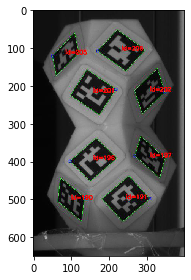

In [7]:
im = io.imread("./_outputs_calibration/img_0099_markers.jpg")
zoomed = im[950:1600, 2400:2800]

io.imshow(zoomed)

_______________
#### v_ graph creation

>If we want to visualize our raw marker/image detection data, we end-up with this graph:

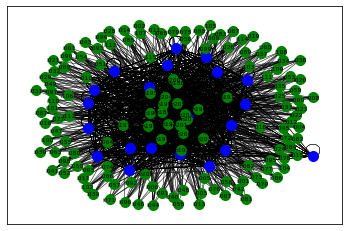

In [8]:
data = batch.merge_all()
batch.multigraph  = pcp.utils.get_multigraph(data=data)
batch.graph  = pcp.utils.get_graph(data=data)
batch.plot_graph()

> *blue nodes: markers | green nodes: images*

_______________
#### vi_ GBU algorithm

>**In order to get rid of the pose ambiguity (cf. [pycopo_theory](./pycopo_theory.md)), we submit our dataframe poses info to the GBU algorithm.**

>>The pose filtration process relies on the get_graph_data function from the pycopo module. Here the detailed process:
    
>>* info extraction from our dataframe batch
>>* graph construction based on the image/marker detection info
>>* GBU algorithm filtration
>>* graph updating with the filtered poses
>>* marker counting, checking if we've lost some ids 

In [9]:
batch.get_graph_data(plot_markers=False, criterion=0.15, atomic_cycle=True, deph_max=1)

Working on cycle: ('m189', 'i115', 'm188', 'i114'): 100%|██████████| 680/680 [00:22<00:00, 30.47it/s]


full data 	= 2010 poses
no valid pose 	= 0 poses
out of cycle 	= 328 poses
good data 	= 411 poses
bad data 	= 1157 poses
ambigus data 	= 114 poses


Working on cycle: ('m193', 'i113', 'm204', 'i112'): 100%|██████████| 308/308 [00:08<00:00, 36.51it/s]


full data 	= 525 poses
no valid pose 	= 0 poses
out of cycle 	= 54 poses
good data 	= 378 poses
bad data 	= 48 poses
ambigus data 	= 10 poses
/!\ we lose marker(s) : {192}


>Once the bad poses cleaned-up, we calibrate our graph in specifying our central markers wich are the graph nodes the most related to the other.

>Here the resulting graph from the whole process:

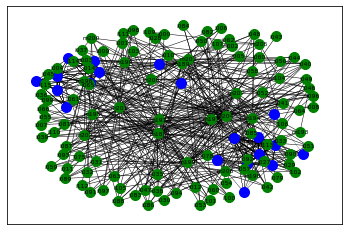

In [10]:
batch.graph_calibration()

batch.plot_graph()

> *blue nodes: markers | green nodes: images*

_______________
#### vii_ Minimizing the reprojection error

>If you don't know what this step stands for, refer to the pycopo theory [corresponding section](./pycopo_theory.md).
>The goal here is to optimize the transformation matrix that allows us to go from the marker detected to the reference marker.
**(marker detected -> reference marker)**.

In [11]:
# batch.optimize_calibration()
# batch.plot_reprojection_errors()

_______________
#### viii_ Composite manipulation

>Once the composite calibrated, we can manipulate it as illustrated with ``set_marker_reference()`` function that change the reference marker of our composite by the one specified in argument:

In [12]:
compo = batch.composites[-1]
compo.set_marker_reference(mk_ref=190, inplace=True)

>We save the composite data in ``.json`` file in order to be reused in other class instance as we're going to do in the following cells. 

In [13]:
dir = "./"
no_compo = True
for file in os.listdir(dir):
    if file == "composite.json":
        no_compo=False
if no_compo: 
    compo.save(path="composite.json")

_______________
#### ix_ plot axis on composite

>In this last part from our tutorial, we are going to plot 3 orthogonals axis on the marker reference from the composite calibrated just above.
>We first initialize an ImageBatchCompositePose class instance called batch_compo with the composite.json file as argument.

In [14]:

batch_compo = pcp.calibration.ImageBatchCompositePose(
    aruco_dict=aruco.DICT_6X6_250,
    parameters=parameters,
    output_directory="./_outputs_composite_pose/",
    camera_matrix=camera_matrix,
    distortion_coefficients=distortion_coefficients,
    directory = image_directory,
    composites={"my_compo":compo}
)

batch_compo.load_image_batch(directory=batch_compo.directory)
batch_compo.detect_markers(plot_markers=False, enforce=False)
batch_compo.estimate_composite_pose(method="pycopo", planar=True)

Estimating composite pose on image: 115: 100%|██████████| 116/116 [00:03<00:00, 37.45it/s]


>Once our image dataset studied and the pose of the composite estimated, we can now call ``draw_xyz_composite()`` function that draws axis on marker reference.

In [15]:
batch_compo.draw_markers().draw_xyz_composite(key="my_compo", dimension=0.1, thickness=5)

Drawing markers...


100%|██████████| 116/116 [01:14<00:00,  1.56it/s]


Drawing markers done


Drawing axis markers on: img_0115.tif: 100%|██████████| 116/116 [01:27<00:00,  1.33it/s]


>Let's have a look on our resulting data:

In [16]:
target_dir = "../build/html/_images/"
files = os.listdir(target_dir)
no_gif = True
for file in files:
    if file == "axis_on_image.gif":
        no_gif = False
if no_gif:
    img = []
    dir = "./_outputs_composite_pose/"
    files = sorted([file for file in os.listdir(dir) if file.endswith(".jpg")], key=lambda x: int(x.split("_")[1]))
    for file in files:
        if file.endswith(".jpg"):
            file_path = os.path.join(dir, file)
            im = Image.open(file_path)
            width, height = im.size
            im = im.resize((int(width/2),int(height/2)))
            img.append(im)
    img[0].save(
        "../build/html/_images/axis_on_image.gif", save_all=True, append_images=img[1:], duration=100, loop=0
    )

![dataset_with_axis](../build/html/_images/axis_on_image.gif)